# Positional embeddings in LLMs: RoPE and XPos

In [257]:
import matplotlib.pyplot as plt
import torch

Rotary Position Embedding (RoPE) and Extrapolatable Position Embedding (XPos) are two popular ways to feed position information into attention. Let's see how they look like and what's the difference between them.

## RoPE

[RoFormer: Enhanced Transformer with Rotary Position Embedding](https://arxiv.org/abs/2104.09864)

RoPE transforms attention keys and queries in the following way: 
- For hidden dimension size `d`, split query/key elements corresponding to one attention head into `d/2` pairs
- For each pair, "mix" two elements by considering them real and imaginary parts of a complex number and then multiplying this number by a complex phase
- Put the elements into their original places in query/key

The complex phase contains the product of the position of the element in the sequence ("time") and the frequency. The frequency depends on the index of the element inside the hidden dimension (0 .. d - 1): elements with lower hidden dimension index are rotating faster than those with higher hidden dimension index (see below)

In [2]:
d = 128  # Head size used by LLaMA

In [214]:
base = 10000  # Base chosen in the paper
freqs = base ** (- 2 * torch.arange((d//2)) / d)  # 

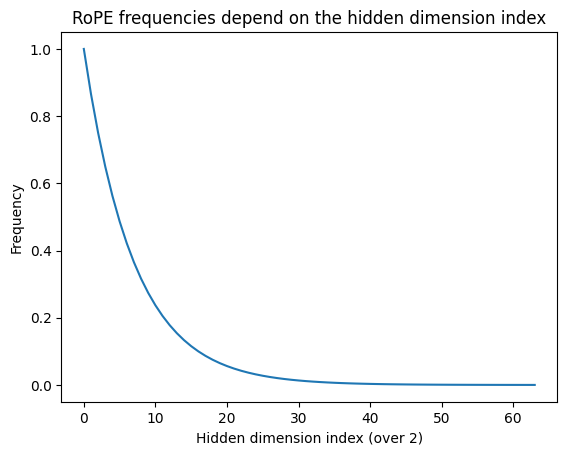

In [261]:
plt.plot(freqs)
plt.xlabel("Hidden dimension index (over 2)")
plt.ylabel("Frequency")
plt.title("RoPE frequencies depend on the hidden dimension index")
plt.show()

Let's visualize the complex phases depending on the time

In [235]:
L = 1024  # Sequence length
time = torch.arange(L).unsqueeze(1)

In [263]:
phases = freqs * time

img_one = torch.complex(torch.tensor(0.), torch.tensor(1.))  # What's the easiest way to create imaginary one in PyTorch?

embs = torch.exp(img_one * freqs * time)

You can see that while the values corresponding to hidden dimension index 0 made a full circle, values with higher  hidden dimension indices moved very little. Note that all points stay on the unit circle - that won't be the case for XPos

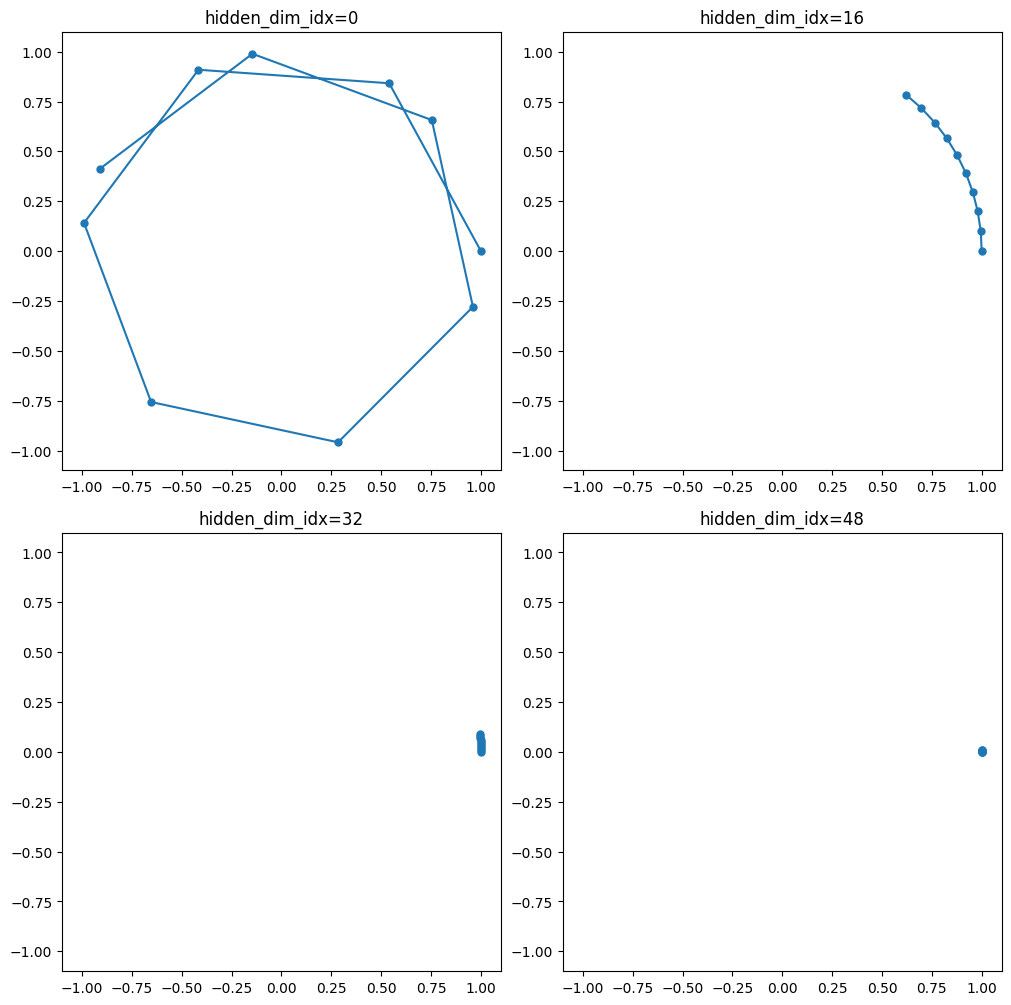

In [266]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10),
                        layout="constrained")
for ax in axs.flat:
    ax.set_aspect(1)
max_time = 10
for i in range(4):
    hidden_dim_idx = ((d // 2) // 4) * i
    ax = axs.flat[i]
    ax.plot(embs.real[:max_time, hidden_dim_idx], embs.imag[:max_time, hidden_dim_idx], label=f"{i}", marker="o", markersize=5)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(f"{hidden_dim_idx=}")

## XPos

[A Length-Extrapolatable Transformer](https://arxiv.org/abs/2212.10554)

RoPE has a problem with long sequence lengths: during inference you won't get good results on sequences significantly longer than the ones used during model training. To make positional embedding "extrapolatable", XPos multiplies RoPE's complex phases by a real factor - exponential decay. Value of the decay, again depends on the hidden dimension index:

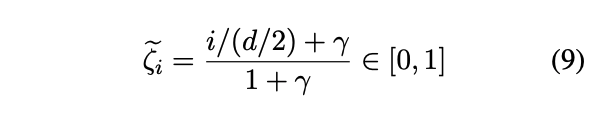

In [283]:
gamma = 5  # Not sure what was the actual value they used
decay = (torch.arange(d // 2) / (d / 2) + gamma) / (1 + gamma)
log_decay = torch.log(decay)

In [284]:
embs = torch.exp((img_one * freqs + log_decay) * time)  # Combine the complex phase and the exponential decay

Now the values simultaneously rotate and approach 0 as time increases. Even though it's hard to see on the plot, the elements with higher hidden dimension indices approach 0 faster than those with lower hidden dimension indices.

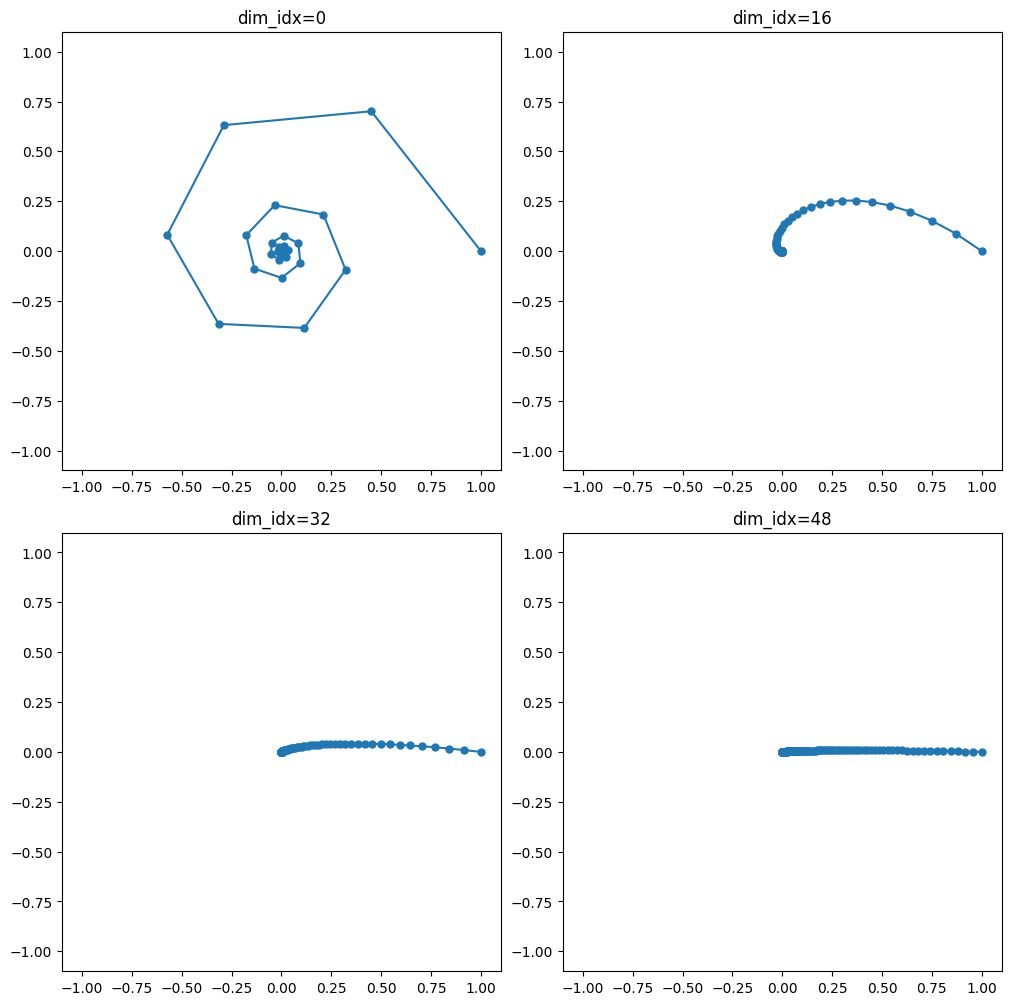

In [285]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10),
                        layout="constrained")
for ax in axs.flat:
    ax.set_aspect(1)
for i in range(4):
    dim_idx = ((d // 2) // 4) * i
    ax = axs.flat[i]
    ax.plot(embs.real[:, dim_idx], embs.imag[:, dim_idx],  label=f"{i}", marker="o", markersize=5)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(f"{dim_idx=}")